# Internet Usage vs Fertility Rate and Life Expectancy
Elian Cesarkas, Roye Grinfeld, Ben Kapner, Micaela Singer



What makes a country considered as underdeveloped? One of the top reasons is low levels of economic growth; Underdeveloped countries typically have low Gross Domestic Product (GDP) per capita and high poverty rates. What is usually also common is that underdeveloped countries have high fertility rate. There is generally an inverse correlation between a country’s GDP and the total fertility rate within and between nations. The higher the degree of GDP per capita, the fewer children are born in any underdeveloped country. The relationship between population growth and economic development is complex and can be influenced by a variety of factors. On one hand, a growing population can provide a larger pool of labor, which can drive economic growth. On the other hand, a rapidly growing population can also put strain on resources and infrastructure, leading to a lower standard of living for individuals and decreased economic growth. So, to make informed decisions about the future, policymakers should know and analyse the trends in future fertility rate as it is a key demographic indicator in their country that can provide important information about economic development. is there a way to predict fertility rate and maybe influence it? In this analysis, we will examine the factors that can help predict the future fertility rate of a country, using two key factors and past data. 

### 1. Importing data

First step for data importing is the installation of pyspark, pyspark.sql and pyspark.pandas.

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 21.4 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=fb9664ccad0eaedd9885bc1aa3bb384f2f3ec13908a4aded90df2f583964eed9
  Stored in directory: /root/.cache/pip/wheels/b1/59/a0/a1a0624b5e865fd389919c1a10f53aec9b12195d6747710baf
Successfully built pyspark


In [2]:
!pip install pyspark.sql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement pyspark.sql (from versions: none)
ERROR: No matching distribution found for pyspark.sql


In [3]:
import pyspark.pandas as ps

/usr/local/lib/python3.8/dist-packages/pyspark/pandas/__init__.py:49: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[1]") \
          .appName("bdp project") \
          .getOrCreate()

Afterwards, the datasets to be analyzed can be loaded.

In [22]:
# Load datasets
fert_by_country = spark.read.format("csv").option("header","true").options(delimiter=';').load('/content/Fertility by country.csv')
country_reg = spark.read.format("csv").option("header","true").options(delimiter=';').load('/content/Country-Region.csv')
fert_by_reg = spark.read.format("csv").option("header","true").options(delimiter=';').load('/content/Fertility by region.csv')
internet_by_reg = spark.read.format("csv").option("header","true").options(delimiter=';').load('/content/Internet use by region.csv')
life_exp = spark.read.format("csv").option("header","true").options(delimiter=';').load('/content/Life expectancy2.csv')
wid_internet = spark.read.format("csv").option("header","true").options(delimiter=';').load('/content/InternetUSe.csv')

The schema of one of the datasets is checked and the dataset itself is shown to get a first perspective of what the data looks like.

In [23]:
# Check schemas
fert_by_reg.printSchema()

root
 |-- Region: string (nullable = true)
 |-- 1950–1955: string (nullable = true)
 |-- 1955–1960: string (nullable = true)
 |-- 1960–1965: string (nullable = true)
 |-- 1965–1970: string (nullable = true)
 |-- 1970–1975: string (nullable = true)
 |-- 1975–1980: string (nullable = true)
 |-- 1980–1985: string (nullable = true)
 |-- 1985–1990: string (nullable = true)
 |-- 1990–1995: string (nullable = true)
 |-- 1995–2000: string (nullable = true)
 |-- 2000–2005: string (nullable = true)
 |-- 2005–2010: string (nullable = true)
 |-- 2010–2015: string (nullable = true)



In [24]:
fert_by_reg.show()

+--------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|              Region|1950–1955|1955–1960|1960–1965|1965–1970|1970–1975|1975–1980|1980–1985|1985–1990|1990–1995|1995–2000|2000–2005|2005–2010|2010–2015|
+--------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|              Africa|     6.62|     6.66|     6.72|     6.72|     6.71|     6.64|     6.48|     6.18|     5.72|     5.34|     5.08|     4.89|     4.72|
|                Asia|      5.8|     5.56|     5.81|     5.73|     5.03|      4.1|      3.7|      3.5|     2.92|     2.56|     2.41|      2.3|      2.2|
|Australia/New Zea...|     3.27|     3.53|     3.38|     2.96|     2.59|     2.02|     1.92|     1.89|      1.9|     1.82|      1.8|     1.99|     1.91|
|           Caribbean|     5.27|     5.19|     5.48|        5|     4.37|     3.62|

### 2. Data Cleaning/Preparation

For the data cleaning, we first start by converting the string values to doubles in order to facilitate further calculations and operations. This process needs is done for the datasets fert_by_reg, fert_by_country and life_exp.

In [25]:
# Change from string format to double

from pyspark.sql.types import DoubleType
cols = ["1950–1955","1955–1960","1960–1965","1965–1970","1970–1975","1975–1980","1980–1985","1985–1990","1990–1995","1995–2000","2000–2005","2005–2010","2010–2015"]

for decade in cols:
  # Fertility by region
  fert_by_reg = fert_by_reg.withColumn(decade, fert_by_reg[decade].cast(DoubleType())) 
  # Fertility by country
  fert_by_country = fert_by_country.withColumn(decade, fert_by_country[decade].cast(DoubleType())) 
  # Life expectancy
  life_exp = life_exp.withColumn(decade, life_exp[decade].cast(DoubleType()))

We check that the schema has changed after the casting operation.

In [26]:
# Check schemas
fert_by_country.printSchema()

root
 |-- Country/dependent territory: string (nullable = true)
 |-- 1950–1955: double (nullable = true)
 |-- 1955–1960: double (nullable = true)
 |-- 1960–1965: double (nullable = true)
 |-- 1965–1970: double (nullable = true)
 |-- 1970–1975: double (nullable = true)
 |-- 1975–1980: double (nullable = true)
 |-- 1980–1985: double (nullable = true)
 |-- 1985–1990: double (nullable = true)
 |-- 1990–1995: double (nullable = true)
 |-- 1995–2000: double (nullable = true)
 |-- 2000–2005: double (nullable = true)
 |-- 2005–2010: double (nullable = true)
 |-- 2010–2015: double (nullable = true)



In [27]:
# Change name of columns to facilitate joins
life_exp = life_exp.withColumnRenamed("Country or subnational area","country_or_area")
fert_by_country = fert_by_country.withColumnRenamed("Country/dependent territory","country")

#show new named column
life_exp.show()

+--------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|     country_or_area|1950–1955|1955–1960|1960–1965|1965–1970|1970–1975|1975–1980|1980–1985|1985–1990|1990–1995|1995–2000|2000–2005|2005–2010|2010–2015|
+--------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|         Afghanistan|    28.61|    31.12|    33.41|    35.58|    37.83|    40.39|    43.56|     47.7|    51.74|    54.17|    56.89|    60.03|    62.25|
|             Albania|    55.26|    59.31|    64.85|    66.24|    67.69|     69.7|    70.61|    71.98|    71.73|    72.95|    74.83|    75.65|    77.66|
|             Algeria|    42.89|     45.0|    47.29|    49.47|    51.48|    54.93|    61.57|    65.85|     67.2|    69.14|     71.5|    73.88|    75.27|
|              Angola|    31.39|    32.54|    34.09|    36.04|    38.05|     40.0|

It is also important to notice that for internet usage, the data starts from 1990. We therefore proceed to drop the columns that have no data (all previous years to 1990).

In [28]:
wid_internet.show()

+-------------------+------------------+------------+--------------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----+-----+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|       Country Name|Is_Under_Developed|Country Code|      Indicator Name|Indicator Code|1960|1961|1962|1963|1964|1965|1966|1967|1968|1969|1970|1971|1972|1973|1974|1975|1976|1977|1978|1979|1980|1981|1982|1983|1984|1985|1986|1987|1988|1989|       1990|       1991|       1992|       1993|       1994|       1995|       1996|       1997|       1998|       1999|       2000|       2001|     

In [29]:
# Drop null columns and columns that won't be used
null_cols = ["Country Code","Indicator Name","Indicator Code","1960","1961","1962","1963","1964","1965","1966",\
             "1967", "1968","1969", "1970", "1971", "1972", "1973", "1974","1975","1976","1977","1978","1979","1980",\
             "1981","1982","1983","1984","1985","1986","1987","1988","1989"]
wid_internet = wid_internet.drop(*null_cols)
wid_internet.show()

+-------------------+------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----+-----+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|       Country Name|Is_Under_Developed|       1990|       1991|       1992|       1993|       1994|       1995|       1996|       1997|       1998|       1999|       2000|       2001|       2002|       2003|       2004|       2005|       2006|       2007|       2008| 2009| 2010|       2011|       2012|       2013|       2014|       2015|       2016|       2017|       2018|       2019|       2020|       2021|
+-------------------+------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--

With the resulting dataframe we can cast the values to convert them to doubles instead of strings.

In [30]:
# Convert 
columns = ["1990","1991","1992","1993","1994","1995","1996","1997","1998","1999","2000","2001",\
           "2002","2003","2004","2005","2006","2007","2008","2009","2010","2011","2012","2013",\
           "2014","2015", "2016", "2017","2018","2019","2020","2021"]
for year in columns:
  # Internet usage
  wid_internet = wid_internet.withColumn(year, wid_internet[year].cast(DoubleType())) 

In [31]:
# Fill nan values in internet dataset
wid_internet = wid_internet.na.fill(value=0)
wid_internet.show()

+-------------------+------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----+-----+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|       Country Name|Is_Under_Developed|       1990|       1991|       1992|       1993|       1994|       1995|       1996|       1997|       1998|       1999|       2000|       2001|       2002|       2003|       2004|       2005|       2006|       2007|       2008| 2009| 2010|       2011|       2012|       2013|       2014|       2015|       2016|       2017|       2018|       2019|       2020|       2021|
+-------------------+------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--

### 3. Data Analysis

We are interested in observing the tendencies and behaviour of fertility rate, life expectancy and internet usage over the years per region.

In [32]:
# Convert dataframe to pandas dataframe
pd_fert_by_reg = fert_by_reg.toPandas()

In [33]:
pd_fert_by_reg.set_index("Region", inplace=True)
pd_fert_by_reg.head()

,1950–1955,1955–1960,1960–1965,1965–1970,1970–1975,1975–1980,1980–1985,1985–1990,1990–1995,1995–2000,2000–2005,2005–2010,2010–2015
Region,,,,,,,,,,,,,
Africa,6.62,6.66,6.72,6.72,6.71,6.64,6.48,6.18,5.72,5.34,5.08,4.89,4.72
Asia,5.80,5.56,5.81,5.73,5.03,4.10,3.70,3.50,2.92,2.56,2.41,2.30,2.20
Australia/New Zealand,3.27,3.53,3.38,2.96,2.59,2.02,1.92,1.89,1.90,1.82,1.80,1.99,1.91
Caribbean,5.27,5.19,5.48,5.00,4.37,3.62,3.41,3.13,2.83,2.64,2.49,2.38,2.28
Central America,6.76,6.81,6.75,6.68,6.55,5.49,4.60,3.99,3.50,3.09,2.80,2.54,2.38


In [34]:
# Transpose for better visualization
pd_fert_by_reg = pd_fert_by_reg.transpose()
pd_fert_by_reg

Region,Africa,Asia,Australia/New Zealand,Caribbean,Central America,Central Asia,Eastern Africa,Eastern Asia,Eastern Europe,Europe,...,Polynesia,South America,Southeast Asia,Southern Africa,Southern Asia,Southern Europe,Sub-Saharan Africa,Western Africa,Western Asia,Western Europe
1950–1955,6.62,5.80,3.27,5.27,6.76,4.86,7.05,5.56,2.92,2.66,...,6.78,5.67,5.93,6.06,6.04,2.68,6.57,6.56,6.15,2.65
1955–1960,6.66,5.56,3.53,5.19,6.81,5.32,7.05,4.98,2.82,2.66,...,6.86,5.67,6.12,6.07,6.06,2.62,6.60,6.63,6.00,2.47
1960–1965,6.72,5.81,3.38,5.48,6.75,5.57,7.11,5.53,2.43,2.57,...,6.82,5.66,6.09,6.03,6.07,2.70,6.67,6.80,5.73,1.96
1965–1970,6.72,5.73,2.96,5.00,6.68,5.16,7.11,5.53,2.15,2.37,...,6.39,5.22,5.91,5.86,5.94,2.68,6.70,6.91,5.36,1.65
1970–1975,6.71,5.03,2.59,4.37,6.55,5.02,7.14,4.36,2.14,2.17,...,5.74,4.60,5.48,5.60,5.67,2.56,6.77,6.87,5.00,1.62
1975–1980,6.64,4.10,2.02,3.62,5.49,4.51,7.10,2.86,2.07,1.98,...,5.23,4.24,4.81,5.19,5.31,2.24,6.78,6.67,4.51,1.57
1980–1985,6.48,3.70,1.92,3.41,4.60,4.13,7.02,2.48,2.08,1.88,...,4.79,3.80,4.20,4.75,5.03,1.83,6.70,6.41,4.03,1.49
1985–1990,6.18,3.50,1.89,3.13,3.99,4.00,6.80,2.59,2.09,1.81,...,4.37,3.30,3.58,4.15,4.57,1.56,6.49,6.16,3.60,1.52
1990–1995,5.72,2.92,1.90,2.83,3.50,3.57,6.41,1.87,1.63,1.57,...,3.96,2.92,3.11,3.50,4.04,1.42,6.16,5.95,3.23,1.59
1995–2000,5.34,2.56,1.82,2.64,3.09,2.89,6.12,1.51,1.30,1.43,...,3.55,2.64,2.69,3.09,3.61,1.34,5.90,5.75,3.02,1.64


In [35]:
# Get a description of the values in the dataframe
pd_fert_by_reg.describe()

Region,Africa,Asia,Australia/New Zealand,Caribbean,Central America,Central Asia,Eastern Africa,Eastern Asia,Eastern Europe,Europe,...,Polynesia,South America,Southeast Asia,Southern Africa,Southern Asia,Southern Europe,Sub-Saharan Africa,Western Africa,Western Asia,Western Europe
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,...,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,6.036923,3.970769,2.383077,3.699231,4.764615,4.070000,6.531538,3.226154,1.990769,1.975385,...,4.919231,3.863846,4.247692,4.500000,4.686154,1.989231,6.268462,6.178462,4.221538,1.786923
std,0.777093,1.450301,0.666438,1.207997,1.803125,1.104649,0.768167,1.699699,0.536958,0.465665,...,1.480582,1.403707,1.538095,1.394465,1.306647,0.592332,0.573467,0.667356,1.308019,0.363304
min,4.720000,2.200000,1.800000,2.280000,2.380000,2.510000,4.890000,1.510000,1.260000,1.430000,...,2.970000,2.030000,2.350000,2.640000,2.540000,1.340000,5.100000,4.880000,2.610000,1.490000
25%,5.340000,2.560000,1.900000,2.640000,3.090000,2.890000,6.120000,1.590000,1.570000,1.570000,...,3.550000,2.640000,2.690000,3.090000,3.610000,1.420000,5.900000,5.750000,3.020000,1.590000
50%,6.480000,3.700000,1.990000,3.410000,4.600000,4.130000,7.020000,2.590000,2.080000,1.880000,...,4.790000,3.800000,4.200000,4.750000,5.030000,1.830000,6.570000,6.410000,4.030000,1.650000
75%,6.660000,5.560000,2.960000,5.000000,6.680000,5.020000,7.100000,4.980000,2.150000,2.370000,...,6.390000,5.220000,5.910000,5.860000,5.940000,2.620000,6.700000,6.670000,5.360000,1.710000
max,6.720000,5.810000,3.530000,5.480000,6.810000,5.570000,7.140000,5.560000,2.920000,2.660000,...,6.860000,5.670000,6.120000,6.070000,6.070000,2.700000,6.780000,6.910000,6.150000,2.650000


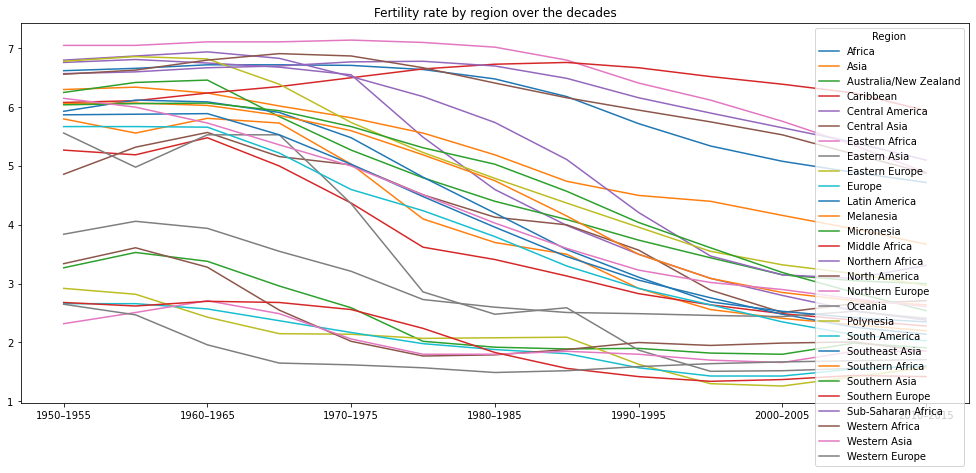

In [36]:
# Plot
pd_fert_by_reg.plot(kind="line", figsize=(17,7), title="Fertility rate by region over the decades")

Next, we analize fertility rate over the years for underdeveloped (is_under_developed=1) and developed countries (is_under_developed=0). For this, we need to join the fertility per country dataset with the country-region dataset.

In [37]:
# Join with country-reg dataset
fert_by_country = fert_by_country.join(country_reg, fert_by_country.country==country_reg.Country, "inner")

In [38]:
# Perform group by for Fertility rate for underdevelopped countries
from pyspark.sql.functions import avg
group_cols = ["Is_Under_Developed"]

fertility_ud = fert_by_country.groupBy(group_cols) \
    .agg(avg("1950–1955").alias("1950–1955"), \
         avg("1955–1960").alias("1955–1960"), \
         avg("1960–1965").alias("1960–1965"), \
         avg("1965–1970").alias("1965–1970"), \
         avg("1970–1975").alias("1970–1975"), \
         avg("1975–1980").alias("1975–1980"), \
         avg("1980–1985").alias("1980–1985"), \
         avg("1985–1990").alias("1985–1990"), \
         avg("1990–1995").alias("1990–1995"), \
         avg("1995–2000").alias("1995–2000"), \
         avg("2000–2005").alias("2000–2005"), \
         avg("2005–2010").alias("2005–2010"), \
         avg("2010–2015").alias("2010–2015"))
fertility_ud.show()

+------------------+-----------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+
|Is_Under_Developed|        1950–1955|        1955–1960|        1960–1965|         1965–1970|        1970–1975|         1975–1980|         1980–1985|         1985–1990|         1990–1995|        1995–2000|        2000–2005|        2005–2010|         2010–2015|
+------------------+-----------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+
|                 0|5.105769230769228|5.155461538461538|5.123769230769229|4.8364615384615375|4.487769230769234| 4.095923076923078|3.7731538461538463|3.4393076923076933|3.0589999999999993|2.697230769230768|2.4483846153

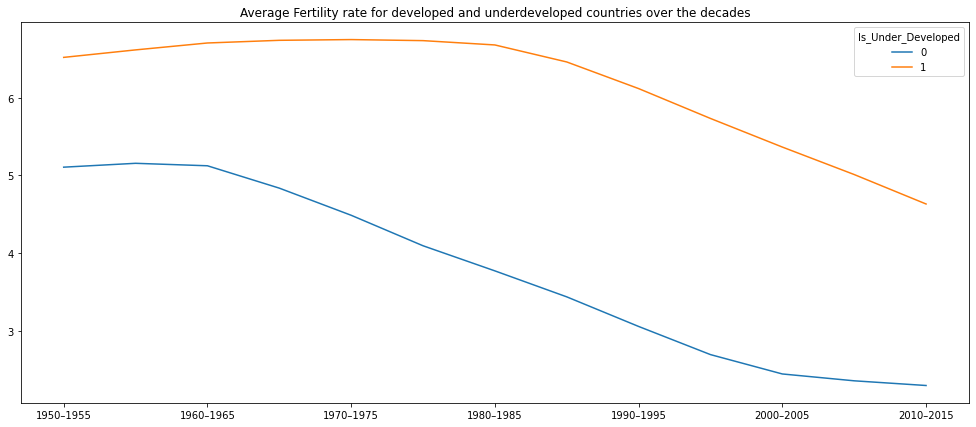

In [39]:
# Plot fertility rate for underdeveloped (1) and developed countries (0)
pd_fertility_ud = fertility_ud.toPandas()
pd_fertility_ud.set_index("Is_Under_Developed", inplace=True)
pd_fertility_ud = pd_fertility_ud.transpose()
pd_fertility_ud.plot(kind="line", figsize=(17,7), title="Average Fertility rate for developed and underdeveloped countries over the decades")

For the life expectancy variable, we join the life expectancy dataset with the country-region dataset to be able to plot the life expectancy over the years per region.

In [40]:
#Inner join to get the life expectancy per region
life_exp = life_exp.join(country_reg, life_exp.country_or_area==country_reg.Country, "inner")

In [41]:
life_exp.show()

+--------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------------+--------+------------------+
|     country_or_area|1950–1955|1955–1960|1960–1965|1965–1970|1970–1975|1975–1980|1980–1985|1985–1990|1990–1995|1995–2000|2000–2005|2005–2010|2010–2015|             Country|  Region|Is_Under_Developed|
+--------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------------+--------+------------------+
|         Afghanistan|    28.61|    31.12|    33.41|    35.58|    37.83|    40.39|    43.56|     47.7|    51.74|    54.17|    56.89|    60.03|    62.25|         Afghanistan|    Asia|                 1|
|             Albania|    55.26|    59.31|    64.85|    66.24|    67.69|     69.7|    70.61|    71.98|    71.73|    72.95|    74.83|    75.65|    77.66|             Albania|  Europe|          

In [42]:
# Group by Region
from pyspark.sql.functions import avg
group_cols = ["Region"]

life_exp_reg = life_exp.groupBy(group_cols) \
    .agg(avg("1950–1955").alias("1950–1955"), \
         avg("1955–1960").alias("1955–1960"), \
         avg("1960–1965").alias("1960–1965"), \
         avg("1965–1970").alias("1965–1970"), \
         avg("1970–1975").alias("1970–1975"), \
         avg("1975–1980").alias("1975–1980"), \
         avg("1980–1985").alias("1980–1985"), \
         avg("1985–1990").alias("1985–1990"), \
         avg("1990–1995").alias("1990–1995"), \
         avg("1995–2000").alias("1995–2000"), \
         avg("2000–2005").alias("2000–2005"), \
         avg("2005–2010").alias("2005–2010"), \
         avg("2010–2015").alias("2010–2015"))
life_exp_reg.show()

+--------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+
|  Region|        1950–1955|         1955–1960|         1960–1965|         1965–1970|         1970–1975|         1975–1980|         1980–1985|         1985–1990|         1990–1995|        1995–2000|        2000–2005|        2005–2010|        2010–2015|
+--------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+
|  Europe|          63.6495|            66.434| 68.40950000000001| 69.44000000000001| 70.32825000000001| 71.18250000000002| 71.93424999999999|           72.9965| 73.31299999999997|74.16299999999998|          75.3635|          76.5415|       

In [43]:
# Convert to Pandas
pd_life_exp_reg = life_exp_reg.toPandas()
pd_life_exp_reg.head()

,Region,1950–1955,1955–1960,1960–1965,1965–1970,1970–1975,1975–1980,1980–1985,1985–1990,1990–1995,1995–2000,2000–2005,2005–2010,2010–2015
0,Europe,63.649500,66.434000,68.409500,69.440000,70.328250,71.182500,71.934250,72.996500,73.313000,74.163000,75.363500,76.541500,78.029750
1,Africa,38.431346,40.586923,42.846731,44.944231,47.261731,49.676923,51.900962,53.343269,53.452885,53.989231,54.940962,58.055385,61.215769
2,Americas,54.189714,56.841429,59.339429,61.349429,63.312571,65.139429,66.891143,68.398571,69.743429,70.913143,72.063714,73.224286,74.264571
3,Oceania,52.347857,54.835714,56.996429,59.108571,61.200000,63.179286,64.922143,66.029286,67.673571,69.267857,70.746429,72.060714,73.172143
4,Asia,48.079149,50.970851,53.617660,56.435319,58.666809,60.302128,62.800426,65.100426,66.679574,68.235532,70.017660,71.557447,72.769787


In [44]:
# Set Region as index
pd_life_exp_reg.set_index("Region", inplace=True)

In [45]:
# Get transpose
pd_life_exp_reg = pd_life_exp_reg.transpose()
pd_life_exp_reg.head()

Region,Europe,Africa,Americas,Oceania,Asia
1950–1955,63.64950,38.431346,54.189714,52.347857,48.079149
1955–1960,66.43400,40.586923,56.841429,54.835714,50.970851
1960–1965,68.40950,42.846731,59.339429,56.996429,53.617660
1965–1970,69.44000,44.944231,61.349429,59.108571,56.435319
1970–1975,70.32825,47.261731,63.312571,61.200000,58.666809


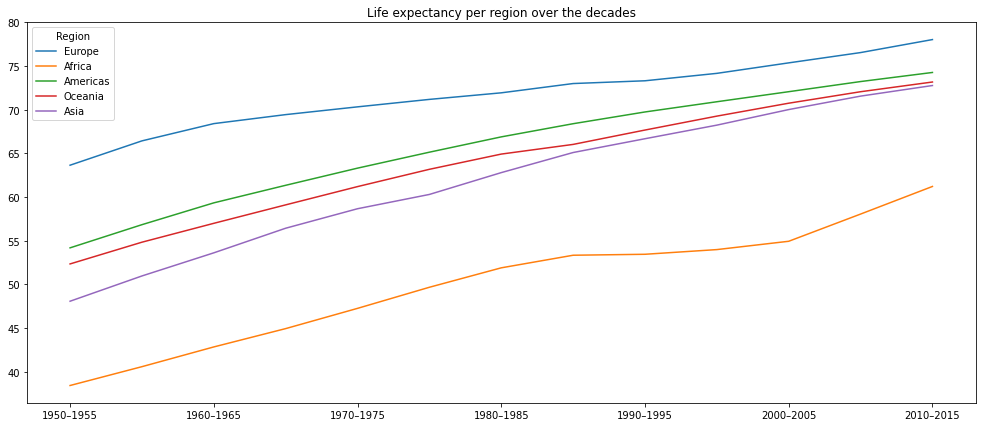

In [46]:
# Plot life expectancy over the years per region
pd_life_exp_reg.plot(kind="line", figsize=(17,7), title="Life expectancy per region over the decades")

Next, we analyze life expectancy over the years for developed (is_under_developed=0) and underdeveloped (is_under_developed=1) countries. 

In [47]:
# Group by for Life Expectancy for underdevelopped countries
group_cols = ["Is_Under_Developed"]

life_exp_ud = life_exp.groupBy(group_cols) \
    .agg(avg("1950–1955").alias("1950–1955"), \
         avg("1955–1960").alias("1955–1960"), \
         avg("1960–1965").alias("1960–1965"), \
         avg("1965–1970").alias("1965–1970"), \
         avg("1970–1975").alias("1970–1975"), \
         avg("1975–1980").alias("1975–1980"), \
         avg("1980–1985").alias("1980–1985"), \
         avg("1985–1990").alias("1985–1990"), \
         avg("1990–1995").alias("1990–1995"), \
         avg("1995–2000").alias("1995–2000"), \
         avg("2000–2005").alias("2000–2005"), \
         avg("2005–2010").alias("2005–2010"), \
         avg("2010–2015").alias("2010–2015"))
life_exp_ud.show()

+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+-----------------+
|Is_Under_Developed|         1950–1955|        1955–1960|        1960–1965|         1965–1970|         1970–1975|        1975–1980|         1980–1985|        1985–1990|         1990–1995|         1995–2000|        2000–2005|        2005–2010|        2010–2015|
+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+-----------------+
|                 0|54.316363636363675|57.10230769230768|59.56223776223776|61.602587412587425|63.469510489510476|65.28902097902098| 66.89048951048953|68.43769230769227| 69.34657342657341| 70.10209790209785| 71.1613286

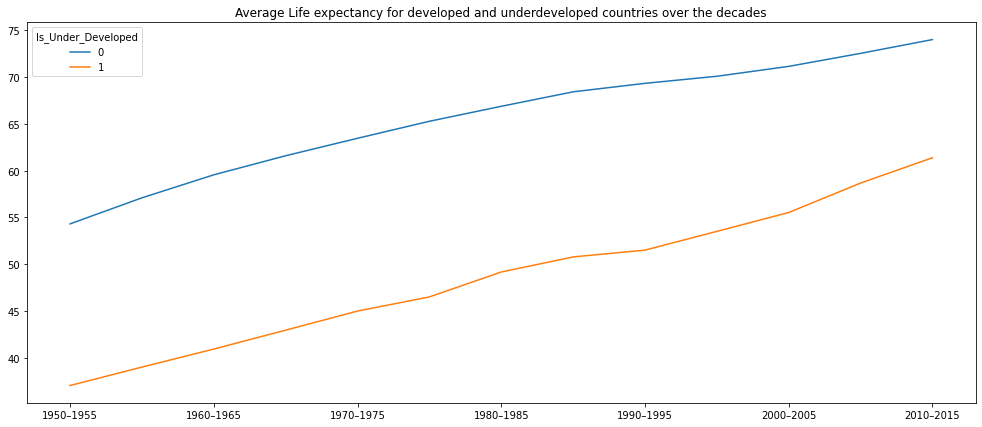

In [48]:
# Plot life expectancy for underdeveloped and developed countries over the years
pd_life_exp_ud = life_exp_ud.toPandas()
pd_life_exp_ud.set_index("Is_Under_Developed", inplace=True)
pd_life_exp_ud = pd_life_exp_ud.transpose()
pd_life_exp_ud.plot(kind="line", figsize=(17,7), title="Average Life expectancy for developed and underdeveloped countries over the decades")

We proceed to analyze our third variable, internet usage.

In [49]:
# Internet use for developed and underdeveloped countries
group_cols = ["Is_Under_Developed"]

wid_internet_ud = wid_internet.groupBy(group_cols) \
    .agg(avg("1990").alias("1990"), \
         avg("1991").alias("1991"), \
         avg("1992").alias("1992"), \
         avg("1993").alias("1993"), \
         avg("1994").alias("1994"), \
         avg("1995").alias("1995"), \
         avg("1996").alias("1996"), \
         avg("1997").alias("1997"), \
         avg("1998").alias("1998"), \
         avg("1999").alias("1999"), \
         avg("2000").alias("2000"), \
         avg("2001").alias("2001"), \
         avg("2002").alias("2002"), \
         avg("2003").alias("2003"), \
         avg("2004").alias("2004"), \
         avg("2005").alias("2005"), \
         avg("2006").alias("2006"), \
         avg("2007").alias("2007"), \
         avg("2008").alias("2008"), \
         avg("2009").alias("2009"), \
         avg("2010").alias("2010"), \
         avg("2011").alias("2011"), \
         avg("2012").alias("2012"), \
         avg("2013").alias("2013"), \
         avg("2014").alias("2014"), \
         avg("2015").alias("2015"), \
         avg("2016").alias("2016"), \
         avg("2017").alias("2017"), \
         avg("2018").alias("2018"), \
         avg("2019").alias("2019"), \
         avg("2020").alias("2020"), \
         avg("2021").alias("2021"))
wid_internet_ud.show()

+------------------+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+
|Is_Under_Developed|                1990|               1991|               1992|               1993|                1994|                1995|                1996|                1997|              1998|               1999|               2000|              2001|              2002|              2003|              2004|              2005|              2006|       

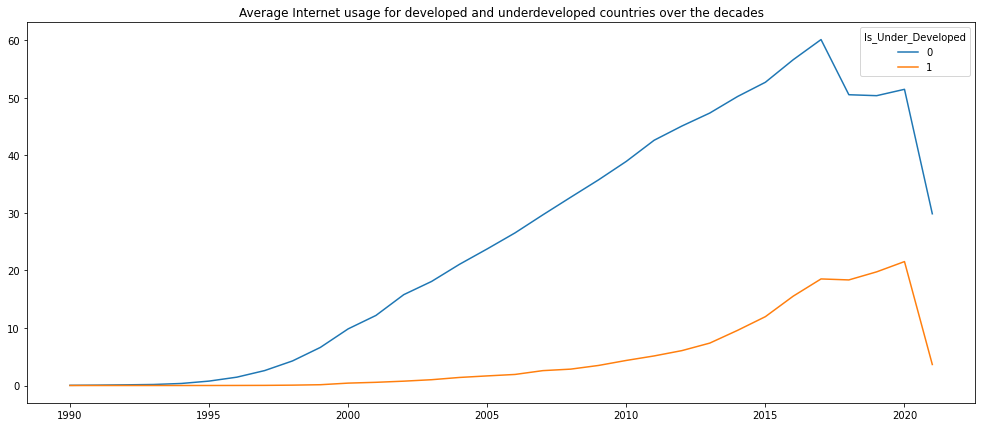

In [50]:
# Plot internet use for underdeveloped and developed countries over the years
wid_internet_ud = wid_internet_ud.toPandas()
wid_internet_ud.set_index("Is_Under_Developed", inplace=True)
wid_internet_ud = wid_internet_ud.transpose()
wid_internet_ud.plot(kind="line", figsize=(17,7), title="Average Internet usage for developed and underdeveloped countries over the decades")

The internet usage dataset is in a different format than the life expectancy and fertility rate dataset. We therefore proceed to modify the internet usage dataset so that it follow the same format as the other two.

In [51]:
# Aggregate the columns in ranges of 5 years from 1990 till 2015 and keep average of internet use
from pyspark.sql.functions import col, avg

nineties1 = [col('1990'), col('1991'), col("1992"), col("1993"), col("1994")]
nineties2 = [col('1995'), col('1996'), col("1997"), col("1998"), col("1999")]
twenties1 = [col("2000"),col("2001"),col("2002"),col("2003"),col("2004")]
twenties2 = [col("2005"),col("2006"),col("2007"),col("2008"),col("2009")]
twenties3 = [col("2010"),col("2011"),col("2012"),col("2013"),col("2014"), col("2015")]

averageFunc1 = sum(x for x in nineties1)/len(nineties1)
averageFunc2 = sum(x for x in nineties2)/len(nineties2)
averageFunc3 = sum(x for x in twenties1)/len(twenties1)
averageFunc4 = sum(x for x in twenties2)/len(twenties2)
averageFunc5 = sum(x for x in twenties3)/len(twenties3)

range1 = wid_internet.withColumn('1990-1995', averageFunc1)
range2 = range1.withColumn('1995-2000', averageFunc2)
range3 = range2.withColumn('2000-2005', averageFunc3)
range4 = range3.withColumn('2005-2010', averageFunc4)
wid_internet = range4.withColumn('2010-2015', averageFunc5)

In [52]:
# Show dataset with changes
# The new columns are added at the end of the dataset
wid_internet.show()

+-------------------+------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----+-----+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------+--------------------+------------------+------------------+------------------+
|       Country Name|Is_Under_Developed|       1990|       1991|       1992|       1993|       1994|       1995|       1996|       1997|       1998|       1999|       2000|       2001|       2002|       2003|       2004|       2005|       2006|       2007|       2008| 2009| 2010|       2011|       2012|       2013|       2014|       2015|       2016|       2017|       2018|       2019|       2020|       2021|           1990-1995|           1995-2000|         2000-2005|         2005-2

In [53]:
# Add columns for year ranges from 1950 till 1990 with 0
from pyspark.sql.functions import lit
wid_internet = wid_internet.withColumn("1950-1955", lit(0))
wid_internet = wid_internet.withColumn("1955-1960", lit(0))
wid_internet = wid_internet.withColumn("1960-1965", lit(0))
wid_internet = wid_internet.withColumn("1965-1970", lit(0))
wid_internet = wid_internet.withColumn("1970-1975", lit(0))
wid_internet = wid_internet.withColumn("1975-1980", lit(0))
wid_internet = wid_internet.withColumn("1980-1985", lit(0))
wid_internet = wid_internet.withColumn("1985-1990", lit(0))
wid_internet.show()

+-------------------+------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----+-----+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------+--------------------+------------------+------------------+------------------+---------+---------+---------+---------+---------+---------+---------+---------+
|       Country Name|Is_Under_Developed|       1990|       1991|       1992|       1993|       1994|       1995|       1996|       1997|       1998|       1999|       2000|       2001|       2002|       2003|       2004|       2005|       2006|       2007|       2008| 2009| 2010|       2011|       2012|       2013|       2014|       2015|       2016|       2017|       2018|       2019|       2020|       2

Now that all the modifications have been done, we proceed to select the relevant columns in the required order so that the internet dataset has the same format as the other two.

In [54]:
# Changing the order of the columns
wid_internet = wid_internet.select("Country Name","Is_Under_Developed","1950-1955","1955-1960","1960-1965","1965-1970",\
                                   "1970-1975", "1975-1980","1980-1985","1985-1990",\
                                   "1990-1995","1995-2000","2000-2005","2005-2010","2010-2015")
wid_internet.show()

+-------------------+------------------+---------+---------+---------+---------+---------+---------+---------+---------+--------------------+--------------------+------------------+------------------+------------------+
|       Country Name|Is_Under_Developed|1950-1955|1955-1960|1960-1965|1965-1970|1970-1975|1975-1980|1980-1985|1985-1990|           1990-1995|           1995-2000|         2000-2005|         2005-2010|         2010-2015|
+-------------------+------------------+---------+---------+---------+---------+---------+---------+---------+---------+--------------------+--------------------+------------------+------------------+------------------+
|        Afghanistan|                 1|        0|        0|        0|        0|        0|        0|        0|        0|                 0.0|                 0.0|      0.0405968492|      2.1242543458| 5.935757575833333|
|            Albania|                 0|        0|        0|        0|        0|        0|        0|        0|        0|

We proceed to calculate the correlation between life expectancy and fertility rate by region over the years.

In [ ]:
# Correlation between life expectancy and fertility rate by region over the years
pd_life_exp_reg.corrwith(pd_fert_by_reg, axis=1)

1950–1955   -0.957738
1955–1960   -0.977858
1960–1965   -0.956358
1965–1970   -0.935552
1970–1975   -0.963247
1975–1980   -0.974386
1980–1985   -0.978827
1985–1990   -0.976793
1990–1995   -0.997688
1995–2000   -0.999655
2000–2005   -0.998486
2005–2010   -0.995872
2010–2015   -0.991809
dtype: float64

### 4. Linear Regression Model

The linear regression model is performed for underdeveloped countries with the fertility rate as the independent variable and life expectancy and internet use as the dependent variables.

In [55]:
# Import required libraries
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

The dataset to be used is obtained by joining all three relevant datasets (fertility rate, life expectancy, internet use) into one with MS-SQL. The dataset considers only the underdeveloped countries.

In [59]:
# Linear regression for underdeveloped countries
df_ud = spark.read.format("csv").option("header","true").options(delimiter=';').load('/content/df_ud.csv')

In [60]:
# Show what the dataset looks like
df_ud.show(3)

+------------+---------+---------------+--------------+------------+
|     Country|    Years|Life_Expectancy|Fertility_Rate|Internet_Use|
+------------+---------+---------------+--------------+------------+
| Afghanistan|1950–1955|          28.61|          7.45|           0|
| Afghanistan|1955–1960|          31.12|          7.45|           0|
| Afghanistan|1960–1965|          33.41|          7.45|           0|
+------------+---------+---------------+--------------+------------+
only showing top 3 rows



The values from the dataset are strings so we proceed to convert them to doubles.

In [63]:
# Convert from string to double
columns = ["Life_Expectancy","Fertility_Rate","Internet_Use"]
for col in columns:
  df_ud = df_ud.withColumn(col, df_ud[col].cast(DoubleType()))

In [64]:
# Create a vector assembler to combine the independent variables into a single feature vector
assembler_ud = VectorAssembler(inputCols=['Life_Expectancy', 'Internet_Use'], outputCol='features')

In [66]:
# Assemble the features into a single column
df_ud = assembler_ud.transform(df_ud)
df_ud = df_ud.select(["features","Fertility_Rate"])
df_ud.show(3)

+-----------+--------------+
|   features|Fertility_Rate|
+-----------+--------------+
|[28.61,0.0]|          7.45|
|[31.12,0.0]|          7.45|
|[33.41,0.0]|          7.45|
+-----------+--------------+
only showing top 3 rows



In [67]:
# Split the data into training and test sets
(train_data, test_data) = df_ud.randomSplit([0.75, 0.25], seed=1234)

In [68]:
# Create a linear regression object and fit the training data
lr_ud = LinearRegression(featuresCol='features', labelCol='Fertility_Rate')
model_ud = lr_ud.fit(train_data)

In [69]:
# Check coefficients and intercept values for underdeveloped countries
print("Coefficients: ", model_ud.coefficients)
print("Intercept: ", model_ud.intercept)

Coefficients:  [-0.054058162507776314,-0.1510976692853022]
Intercept:  8.896046772968862


In [70]:
# Use the model to make predictions on the test data
predictions_ud = model_ud.transform(test_data)

In [72]:
# Evaluate the model using the mean squared error
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol='Fertility_Rate', predictionCol='prediction', metricName='mse')
mse = evaluator.evaluate(predictions_ud)
print('Mean Squared Error = %.2f' % mse)

Mean Squared Error = 0.63


To visualize how the predictions are against the original values we for a new table and use it to plot the results.

In [74]:
mdata_ud = model_ud.transform(df_ud)
mdata_ud.show(3)

+-----------+--------------+-----------------+
|   features|Fertility_Rate|       prediction|
+-----------+--------------+-----------------+
|[28.61,0.0]|          7.45|7.349442743621382|
|[31.12,0.0]|          7.45|7.213756755726863|
|[33.41,0.0]|          7.45|7.089963563584056|
+-----------+--------------+-----------------+
only showing top 3 rows



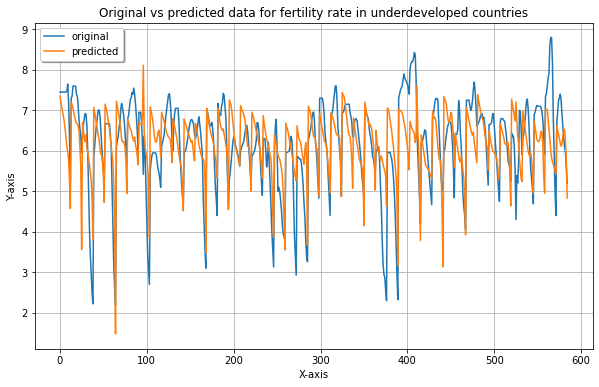

In [75]:
# Plot data
import matplotlib.pyplot as plt
x_ax = range(0, mdata_ud.count())
y_pred = mdata_ud.select("prediction").collect()
y_orig = mdata_ud.select("Fertility_Rate").collect()  

plt.figure(figsize=(10,6))
plt.plot(x_ax, y_orig, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Original vs predicted data for fertility rate in underdeveloped countries")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)

plt.show()